In [2]:
import numpy as np
from scipy.stats import multinomial
import matplotlib.pyplot as plt
import pandas as pd

# Theta

The DB_V and DB_H events do not occur independently across the trials.

The 'DB_V', 'DB_H' and 'neither' events occur in the N samples as a multinomial distribution.

## As per paper

In [3]:
# plot the multinomial distribution

n = 40

theta = 0.25 * np.pi

p_dbh = 1 / 4 * (1 + np.cos(theta)) **2
p_dbv = 1 / 4 * (1 - np.cos(theta)) **2

p_neither = 1 - p_dbh - p_dbv

p = [p_dbh, p_dbv, p_neither]

multinom_db = multinomial(n, p)

multinom_db.pmf([40, 0, 0])

np.float64(3.1510503835036592e-06)

In [4]:
def get_multinom_difference_pmf(n, theta):
    z_range = np.arange(-n, n+1)
    pmf_z = np.zeros(2*n+1)

    p_dbh = 1 / 4 * (1 + np.cos(theta)) **2
    p_dbv = 1 / 4 * (1 - np.cos(theta)) **2
    p_neither = 1 - p_dbh - p_dbv

    p = [p_dbh, p_dbv, p_neither]

    multinom_db = multinomial(n, p)

    range_i = np.arange(0, n+1)

    # https://math.stackexchange.com/questions/562119/difference-of-two-binomial-random-variables
    for i,z in enumerate(z_range):
        pmf_z[i] = np.sum([multinom_db.pmf([z+i, i, n - z - 2*i]) for i in range_i])

    return z_range, pmf_z


In [5]:
def get_multinom_difference_pmf(n, theta):
    p_dbh = 1 / 4 * (1 + np.cos(theta)) **2
    p_dbv = 1 / 4 * (1 - np.cos(theta)) **2
    p_neither = 1 - p_dbh - p_dbv
    
    p = [p_dbh, p_dbv, p_neither]
    multinom_db = multinomial(n, p)

    n_counts = [[i, j, n - i - j] for i in range(n+1) for j in range(n+1 - i)]

    pmf_counts = multinom_db.pmf(n_counts)

    pmf_cos_theta = pd.DataFrame(n_counts)

    pmf_cos_theta["pmf"] = pmf_counts
    pmf_cos_theta["n_dbh"] = pmf_cos_theta[0].astype(int)
    pmf_cos_theta["n_dbv"] = pmf_cos_theta[1].astype(int)
    pmf_cos_theta["n_neither"] = pmf_cos_theta[2].astype(int)

    pmf_cos_theta["numerator"] = pmf_cos_theta["n_dbh"] - pmf_cos_theta["n_dbv"]
    pmf_cos_theta["denominator"] = pmf_cos_theta["n_dbh"] + pmf_cos_theta["n_dbv"] + pmf_cos_theta["n_neither"]
    pmf_cos_theta["cos_theta"] = pmf_cos_theta["numerator"] / pmf_cos_theta["denominator"]
    pmf_cos_theta["pmf_theta_tilde"] = np.arccos(pmf_cos_theta["cos_theta"])

    # sum up contributions for the same theta_tilde
    pmf_cos_theta = pmf_cos_theta.groupby("pmf_theta_tilde").sum()["pmf"]
    pmf_cos_theta = pmf_cos_theta.reset_index()

   # renormalise to account for rounding errors
    pmf_cos_theta["pmf"] = pmf_cos_theta["pmf"] / np.sum(pmf_cos_theta["pmf"])

    return pmf_cos_theta


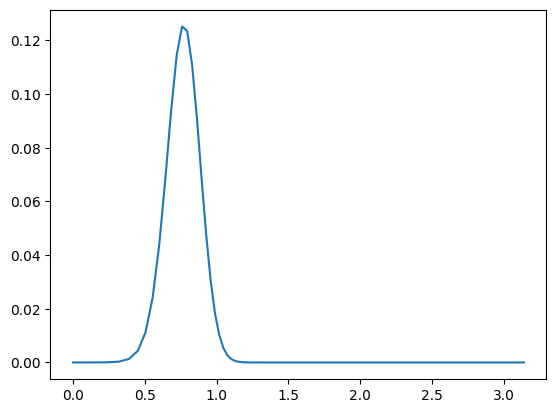

In [6]:
num_samples = 40
pmf_z = get_multinom_difference_pmf(num_samples, 0.25*np.pi)
plt.plot(pmf_z["pmf_theta_tilde"], pmf_z["pmf"])
plt.show()

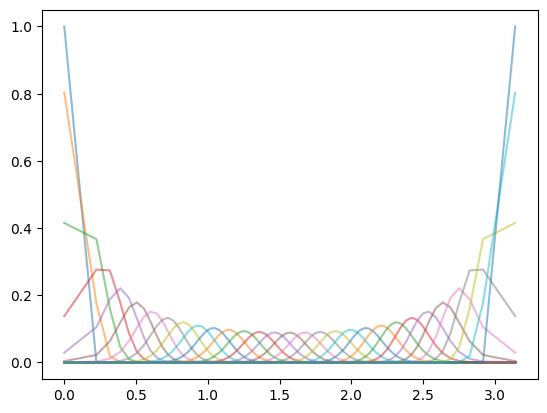

In [7]:
# show some of the pmfs for different thetas
theta_range = np.linspace(0, np.pi, 31)

# get the pmf for each theta
pmfs = [get_multinom_difference_pmf(n, theta) for theta in theta_range]

# plot the pmfs
plt.figure()
for pmf in pmfs:
    plt.plot(pmf["pmf_theta_tilde"], pmf["pmf"], alpha=0.5)

plt.show()

In [8]:
def calculate_multinom_stats(theta_samples, n):
    theta_range = np.linspace(0, np.pi, theta_samples)
    pmfs = [get_multinom_difference_pmf(n, theta) for theta in theta_range]

    variances = []
    means = []

    for pmf in pmfs:
        mean = np.sum(pmf["pmf_theta_tilde"] * pmf["pmf"])
        var = np.sum(pmf["pmf_theta_tilde"]  ** 2 * pmf["pmf"]) - mean ** 2

        means.append(mean)
        variances.append(var)

    return theta_range, means, variances


In [9]:
theta_samples = 501
n = 100
theta_range, means, variances = calculate_multinom_stats(theta_samples, n)

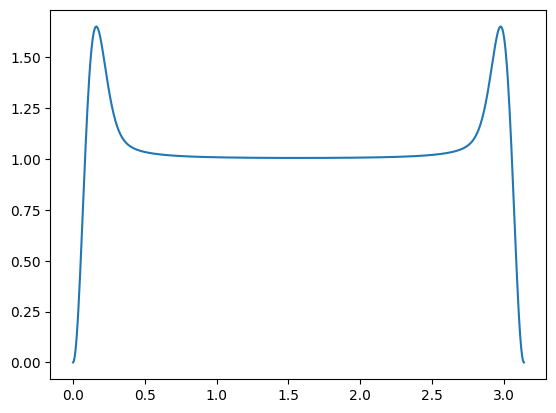

In [10]:
plt.plot(theta_range, np.multiply(2*n, variances))
plt.show()

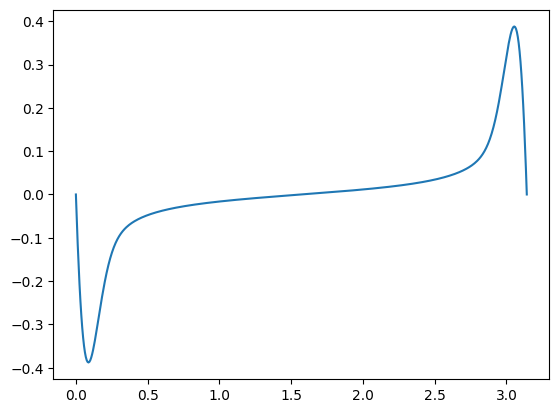

In [11]:
plt.plot(theta_range, np.multiply(np.sqrt(n), means - theta_range))
plt.show()

In [12]:
theta_samples = 501
n_range = [40,200]
theta_range = np.linspace(0, np.pi, theta_samples)

In [13]:
# get the means and variances for each n
means = []
variances = []

for n in n_range:
    _, m, v = calculate_multinom_stats(theta_samples, n)
    means.append(m)
    variances.append(v)

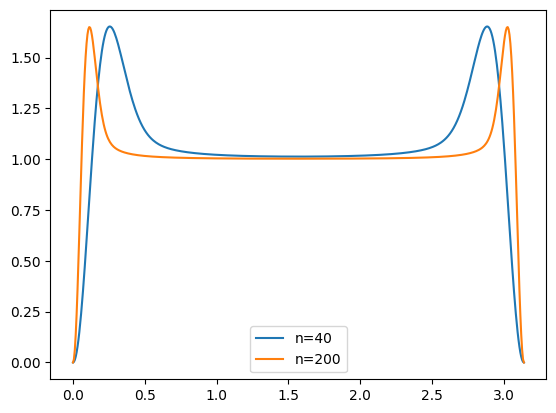

In [14]:
plt.figure()
for n in n_range:
    plt.plot(theta_range, np.multiply(2*n, variances[n_range.index(n)]), label=f'n={n}')

plt.legend()
plt.show()


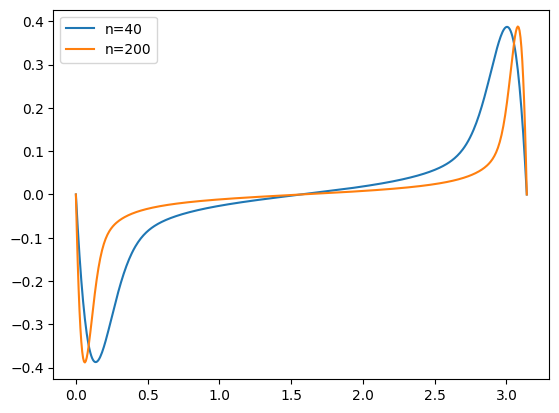

In [15]:
plt.figure()
for n in n_range:
    plt.plot(theta_range, np.multiply(np.sqrt(n), means[n_range.index(n)] - theta_range), label=f'n={n}')

plt.legend()
plt.show()

## Adding PPNRD

### Estimating N

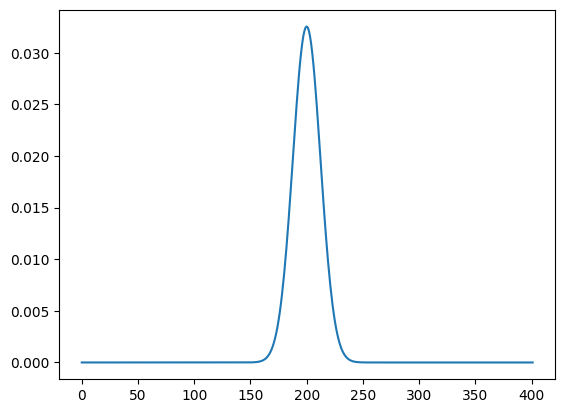

In [ ]:
# n_tilde = n_dc + n_ppnrd
# n_dc: double click events
# n_ppnrd: ppnrd-resolved events
n=200

theta = np.pi / 4
p_dc = 1/2 * (np.sin(theta)) ** 2
p_ppnrd = 1/4 * (1 + np.cos(theta) **2)

p_neither = 1 - p_dc - p_ppnrd

p = [p_dc, p_ppnrd, p_neither]
multinom_n_tilde = multinomial(n, p)

# calculate the pmf for n_tilde
pmf = np.zeros(2*(n+1))

for n_tilde in range(2*(n+1)): # can over estimate n if all events are double clicks
    pmf[n_tilde] = np.sum([multinom_n_tilde.pmf([n_dc, (n_tilde-n_dc)/2, n - n_dc - (n_tilde-n_dc) /2]) for n_dc in range(n+1)])

# plot
plt.plot(range(2*(n+1)), pmf)
plt.show()



This will be necessary when it comes to saying how close we are to saturating the bound, since we will need to estimate the value of N to know what the bound is.

### Re-estimating theta with Ñ

With $\tilde{\theta} = \arccos (\frac{2(N_{DB_{H}}'+N_{DB_{V}}')}{\tilde{N}})$ where $\tilde{N} = 2(N_{DB_{H}}' + N_{DB_{V}}') + N_{dc}$ 

In [ ]:
n = 40

theta = 0.25 * np.pi
delta = 0.25 * np.pi

p_hr = 1 / 8 * (1 + np.cos(theta)) **2
p_vr = 1 / 8 * (1 - np.cos(theta)) **2
p_dc = 1 / 2 * (np.sin(theta)) ** 2 
p_other = 1 - p_hr - p_vr - p_dc # lost event

p = [p_hr, p_vr, p_dc, p_other]

multinom_db = multinomial(n, p)

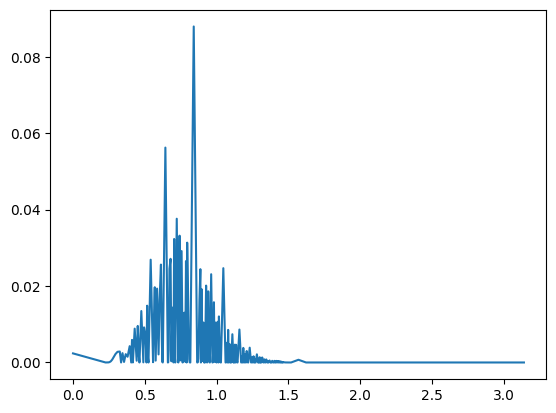

In [ ]:
def get_multinom_ppnrd_ratio_pmf(n, theta):
    p_hr = 1 / 8 * (1 + np.cos(theta)) **2
    p_vr = 1 / 8 * (1 - np.cos(theta)) **2
    p_dc = 1 / 2 * (np.sin(theta)) ** 2
    p_other = 1 - p_hr - p_vr - p_dc

    p = [p_hr, p_vr, p_dc, p_other]

    multinom_ppnrd = multinomial(n, p)

    n_counts = [[k, l, m, n-k-l-m] for k in range(n+1) for l in range(n+1-k) for m in range(n+1-k-l)]

    # calculate the pmf
    pmf_counts = multinom_ppnrd.pmf(n_counts)

    # arrange in pd data frame with counts as columns
    pmf_cos_theta = pd.DataFrame(n_counts)
    pmf_cos_theta["pmf"] = pmf_counts
    pmf_cos_theta["n_hr"] = pmf_cos_theta[0].astype(int)
    pmf_cos_theta["n_vr"] = pmf_cos_theta[1].astype(int)
    pmf_cos_theta["n_dc"] = pmf_cos_theta[2].astype(int)
    pmf_cos_theta["n_other"] = pmf_cos_theta[3].astype(int)

    pmf_cos_theta["numerator"] = 2 * (pmf_cos_theta["n_hr"] - pmf_cos_theta["n_vr"])
    pmf_cos_theta["denominator"] = 2 * (pmf_cos_theta["n_hr"] + pmf_cos_theta["n_vr"]) + pmf_cos_theta["n_dc"]
    pmf_cos_theta["cos_theta"] = pmf_cos_theta["numerator"] / pmf_cos_theta["denominator"]
    pmf_cos_theta["pmf_theta_tilde"] = np.arccos(pmf_cos_theta["cos_theta"])

    # sum up contributions for the same theta_tilde
    pmf_cos_theta = pmf_cos_theta.groupby("pmf_theta_tilde").sum()["pmf"]
    pmf_cos_theta = pmf_cos_theta.reset_index()

    # renormalise to account for rounding errors
    pmf_cos_theta["pmf"] = pmf_cos_theta["pmf"] / np.sum(pmf_cos_theta["pmf"])

    return pmf_cos_theta

num_samples = 20
pmf_s = get_multinom_ppnrd_ratio_pmf(num_samples, 0.25*np.pi)
plt.plot(pmf_s["pmf_theta_tilde"], pmf_s["pmf"])
plt.show()

In [ ]:
# should be 1
# could be less because of values outside the range [-1, 1] which do not give a valid theta
sum(pmf_s["pmf"])

0.9999999999999999

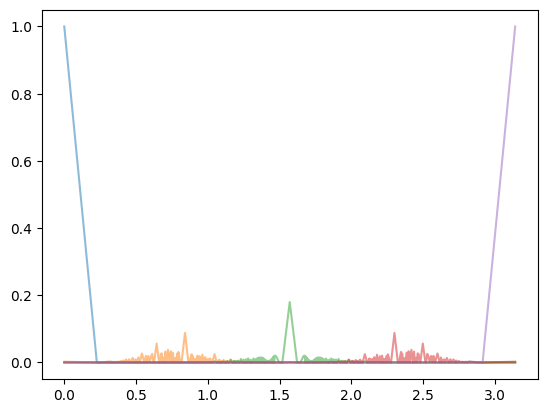

In [ ]:
# show some of the pmfs for different thetas
theta_range = np.linspace(0, np.pi, 5)

# get the pmf for each theta
n=20
pmf_z = [get_multinom_ppnrd_ratio_pmf(n, theta) for theta in theta_range]

# plot the pmfs
plt.figure()
for pmf in pmf_z:
    plt.plot(pmf["pmf_theta_tilde"], pmf["pmf"], alpha=0.5)

plt.show()

In [ ]:
def calculate_multinom_ppnrd_stats(theta_samples, n):
    theta_range = np.linspace(0, np.pi, theta_samples)
    pmf_z = [get_multinom_ppnrd_ratio_pmf(n, theta) for theta in theta_range]
    
    variances = []
    means = []

    for pmf in pmf_z:
        theta_tilde = pmf["pmf_theta_tilde"]
        pmf = pmf["pmf"]

        mean = np.sum(theta_tilde * pmf)
        var = np.sum((theta_tilde) ** 2 * pmf) - mean ** 2

        means.append(mean)
        variances.append(var)

    return theta_range, means, variances


In [ ]:
theta_samples = 11
n = 20
theta_range, means, variances = calculate_multinom_ppnrd_stats(theta_samples, n)

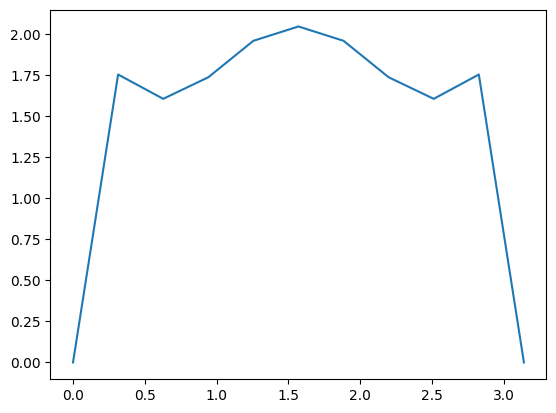

In [ ]:
plt.plot(theta_range, np.multiply(2*n, variances))
plt.show()

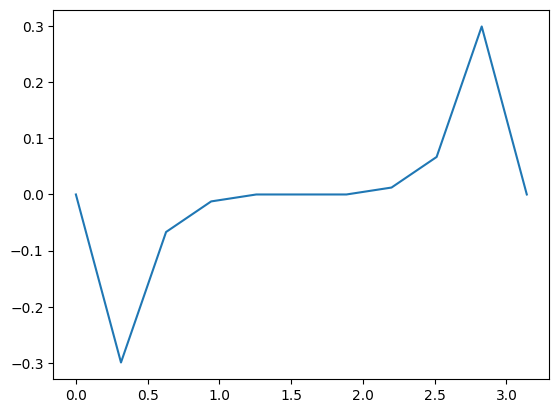

In [ ]:
plt.plot(theta_range, np.multiply(means - theta_range, np.sqrt(n)))
plt.show()

In [ ]:
theta_samples = 11
n = 40
theta_range, means, variances = calculate_multinom_ppnrd_stats(theta_samples, n)

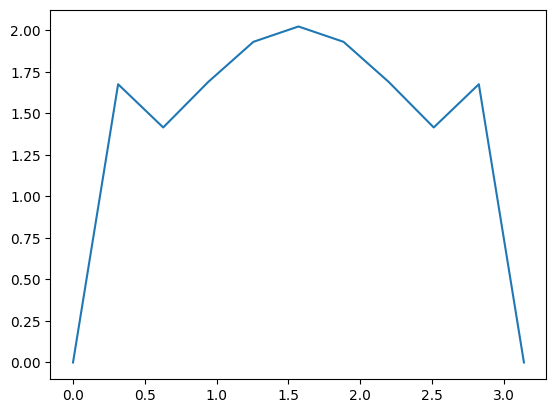

In [ ]:
plt.plot(theta_range, np.multiply(2*n, variances))
plt.show()

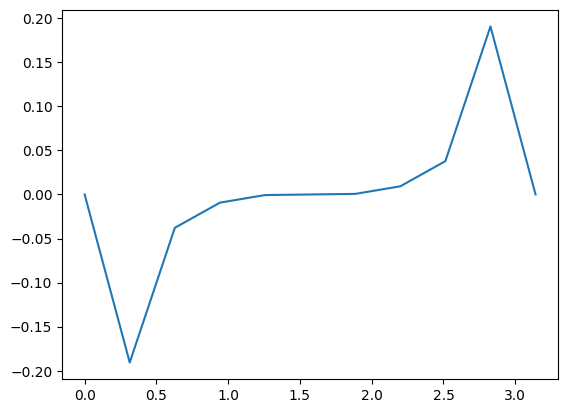

In [ ]:
plt.plot(theta_range, np.multiply(means - theta_range, np.sqrt(n)))
plt.show()

In [ ]:
theta_samples = 101
n = 80
theta_range, means, variances = calculate_multinom_ppnrd_stats(theta_samples, n)

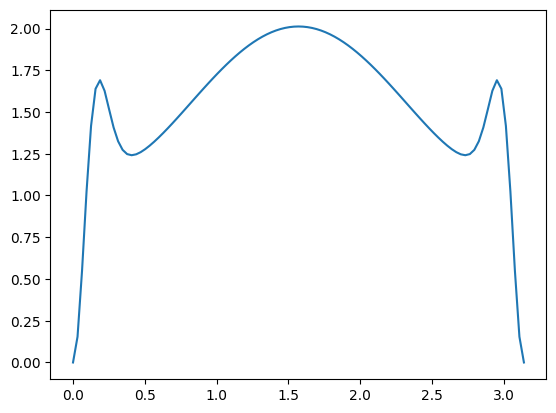

In [ ]:
plt.plot(theta_range, np.multiply(2*n, variances))
plt.show()

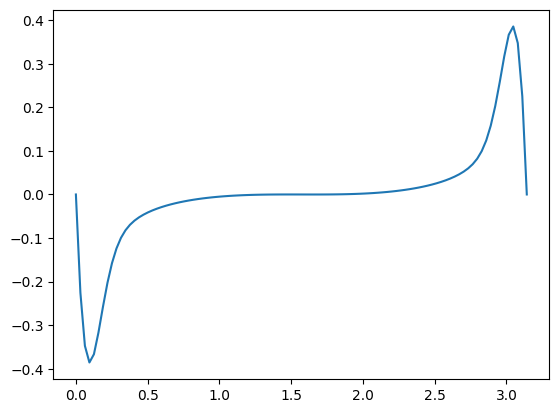

In [ ]:
plt.plot(theta_range, np.multiply(means - theta_range, np.sqrt(n)))
plt.show()

### Ammended distributions excluding lost events

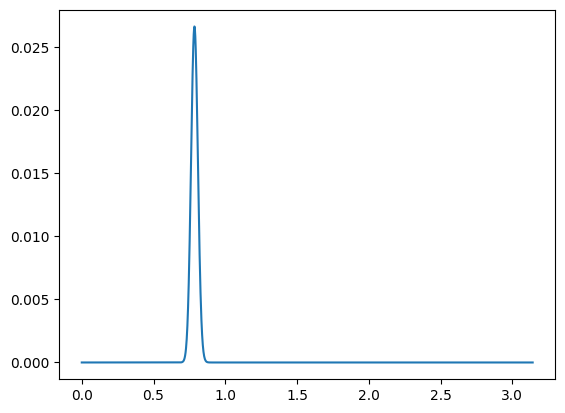

In [ ]:
def get_multinom_ppnrd_ratio_pmf(n, theta):
    p_hr = 2 * (np.cos(theta / 2) **4) / (3 - np.cos(theta) ** 2)
    p_vr = 2 * (np.sin(theta / 2) **4) / (3 - np.cos(theta) ** 2)
    p_dc = 2 * (np.sin(theta)) ** 2 / (3 - np.cos(theta) ** 2)

    p = [p_hr, p_vr, p_dc]

    multinom_ppnrd = multinomial(n, p)

    # arrange all quadruples of counts 0, 1, 2, ..., n in pd data frame
    #n_counts = pd.DataFrame([{"n_hr": k ,"n_vr": l, "n_dc": m, "n_lost": n-k-l-m} for k in range(n+1) for l in range(n+1) for m in range(n+1)])
    n_counts = [[k, l, n-k-l] for k in range(n+1) for l in range(n+1-k)]

    # calculate the pmf
    pmf_counts = multinom_ppnrd.pmf(n_counts)

    # arrange in pd data frame with counts as columns
    pmf_cos_theta = pd.DataFrame(n_counts)
    pmf_cos_theta["pmf"] = pmf_counts
    pmf_cos_theta["n_hr"] = pmf_cos_theta[0].astype(int)
    pmf_cos_theta["n_vr"] = pmf_cos_theta[1].astype(int)
    pmf_cos_theta["n_dc"] = pmf_cos_theta[2].astype(int)

    pmf_cos_theta["under_the_sqrt"] = n**2 + 3 * (pmf_cos_theta["n_hr"] - pmf_cos_theta["n_vr"])**2
    pmf_cos_theta["numerator"] = -n + np.sqrt(pmf_cos_theta["under_the_sqrt"])
    pmf_cos_theta["denominator"] = pmf_cos_theta["n_hr"] - pmf_cos_theta["n_vr"]

    pmf_cos_theta["cos_theta"] = pmf_cos_theta["numerator"] / pmf_cos_theta["denominator"]

    pmf_cos_theta["pmf_theta_tilde"] = np.arccos(pmf_cos_theta["cos_theta"])

    # sum up contributions for the same theta_tilde
    pmf_cos_theta = pmf_cos_theta.groupby("pmf_theta_tilde").sum()["pmf"]
    pmf_cos_theta = pmf_cos_theta.reset_index()

    # renormalise to account for rounding errors
    pmf_cos_theta["pmf"] = pmf_cos_theta["pmf"] / np.sum(pmf_cos_theta["pmf"])

    return pmf_cos_theta

num_samples = 800
pmf_s = get_multinom_ppnrd_ratio_pmf(num_samples, 0.25*np.pi)
plt.plot(pmf_s["pmf_theta_tilde"], pmf_s["pmf"])
plt.show()


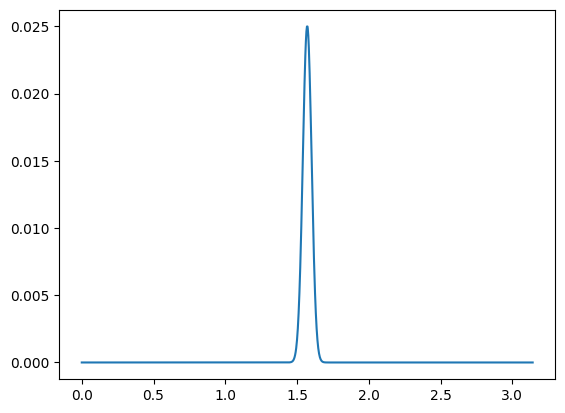

In [ ]:
num_samples = 800
pmf_s = get_multinom_ppnrd_ratio_pmf(num_samples, np.pi / 2)
plt.plot(pmf_s["pmf_theta_tilde"], pmf_s["pmf"])
plt.show()

In [ ]:
# sum of the pmf should be 1
sum(pmf_s["pmf"])

1.0

In [ ]:
def calculate_multinom_ppnrd_stats(theta_samples, n):
    theta_range = np.linspace(0, np.pi, theta_samples)
    pmf_z = [get_multinom_ppnrd_ratio_pmf(n, theta) for theta in theta_range]
    
    variances = []
    means = []

    for df in pmf_z:
        theta_tilde = df["pmf_theta_tilde"]
        pmf = df["pmf"]

        mean = np.sum(theta_tilde * pmf)
        var = np.sum((theta_tilde - mean) ** 2 * pmf) 

        means.append(mean)
        variances.append(var)

    return theta_range, means, variances

theta_samples = 1001
n = 80
theta_range, means, variances = calculate_multinom_ppnrd_stats(theta_samples, n)


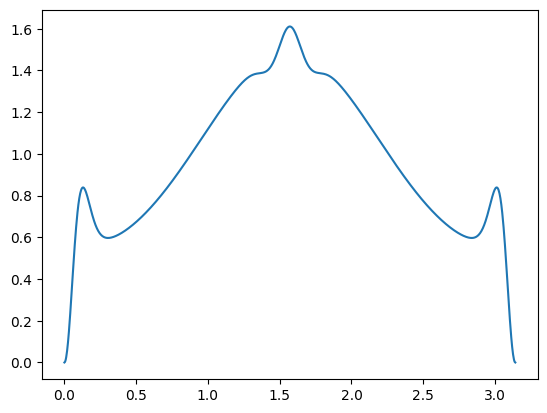

In [ ]:
plt.plot(theta_range, np.multiply(2*n, variances))
plt.show()

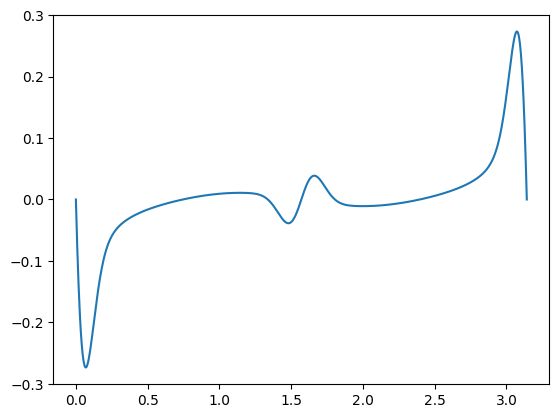

In [ ]:
plt.plot(theta_range, np.multiply(means - theta_range, np.sqrt(n)))
plt.show()

Not sure if the bump around pi/2 is because of rounding errors or genuine variance

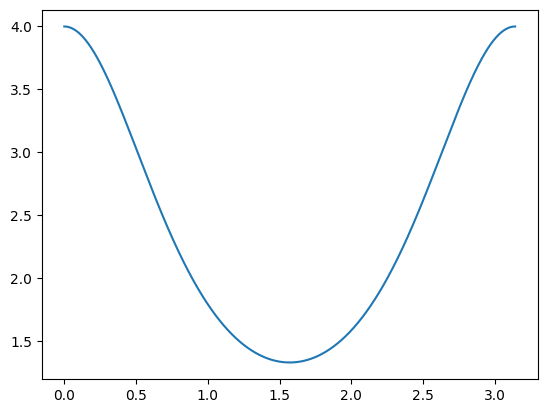

In [ ]:
# plot the fisher information
fisher_information_numerator = 4 * (3 + np.cos(theta_range) ** 2)
fisher_information_denominator = (3 - np.cos(theta_range) ** 2) ** 2
fisher_information = fisher_information_numerator / fisher_information_denominator

plt.plot(theta_range, fisher_information)
plt.show()


In [ ]:
# get the means and variances for each n
means = []
variances = []

theta_samples = 501
n_range = [40,200]
theta_range = np.linspace(0, np.pi, theta_samples)

for n in n_range:
    _, m, v = calculate_multinom_ppnrd_stats(theta_samples, n)
    means.append(m)
    variances.append(v)

In [ ]:
fisher_information_numerator = 4 * (3 + np.cos(theta_range) ** 2)
fisher_information_denominator = (3 - np.cos(theta_range) ** 2) ** 2
fisher_information = fisher_information_numerator / fisher_information_denominator

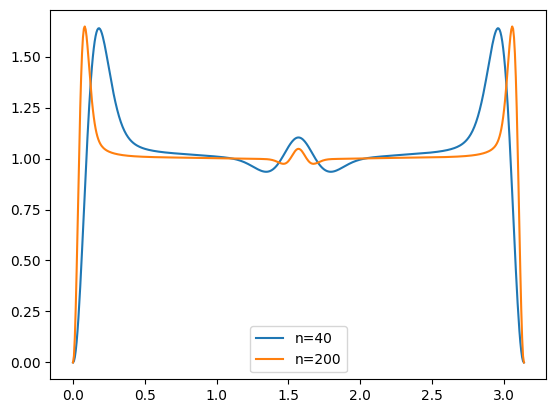

In [ ]:
plt.figure()
for n in n_range:
    plt.plot(theta_range, np.multiply(fisher_information * n, variances[n_range.index(n)]), label=f'n={n}')

plt.legend()
plt.show()

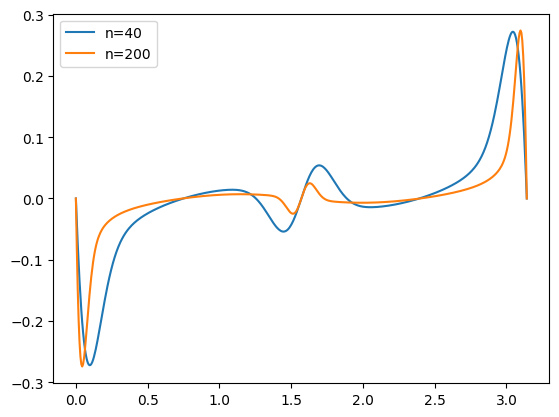

In [ ]:
plt.figure()
for n in n_range:
    plt.plot(theta_range, np.multiply(means[n_range.index(n)] - theta_range, np.sqrt(n)), label=f'n={n}')
    
plt.legend()
plt.show()

# Delta

## As per paper

In [27]:
# plot the multinomial distribution

n = 40

theta = 0.5 * np.pi
delta = 0.25 * np.pi

p_c = 1 / 2 * np.sin(theta) ** 2 * np.sin(delta) ** 2
p_sb = 1 / 2 * np.sin(theta) ** 2 * np.cos(delta) ** 2

p_neither = 1 - p_c - p_sb

p = [p_c, p_sb, p_neither]

multinom_db = multinomial(n, p)

multinom_db.pmf([10, 10, 20])

np.float64(0.022089945566027936)

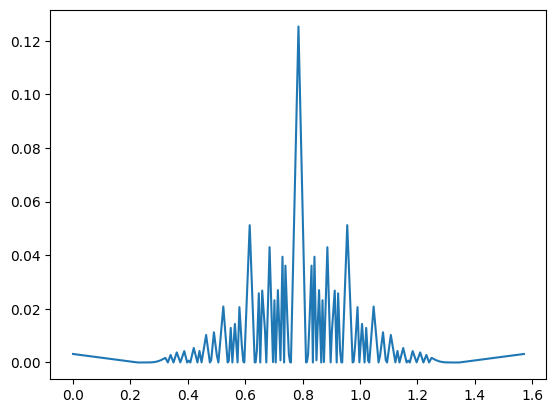

In [79]:
def get_multinom_arctan_pmf(n, theta, delta):
    p_c = 1 / 2 * np.sin(theta) ** 2 * np.sin(delta) ** 2
    p_sb = 1 / 2 * np.sin(theta) ** 2 * np.cos(delta) ** 2

    p_neither = 1 - p_c - p_sb

    p = [p_c, p_sb, p_neither]
    multinom_db = multinomial(n, p)

    n_counts = [[i, j, n - i - j] for i in range(n + 1) for j in range(n + 1 - i)]

    pmf_counts = multinom_db.pmf(n_counts)

    pmf = pd.DataFrame(n_counts)

    pmf["pmf"] = pmf_counts
    pmf["n_c"] = pmf[0].astype(int)
    pmf["n_sb"] = pmf[1].astype(int)
    pmf["n_neither"] = pmf[2].astype(int)

    pmf["under_the_root"] = pmf["n_c"] / pmf["n_sb"]
    pmf["arctan_argument"] = np.sqrt(pmf["under_the_root"])
    pmf["pmf_delta_tilde"] = np.arctan(pmf["arctan_argument"])

    # sum up contributions for the same theta_tilde
    pmf = pmf.groupby("pmf_delta_tilde").sum()["pmf"]
    pmf = pmf.reset_index()

    # renormalise to account for rounding errors
    pmf["pmf"] = pmf["pmf"] / np.sum(pmf["pmf"])

    return pmf


num_samples = 20
pmf_s = get_multinom_arctan_pmf(num_samples, 0.5 * np.pi, 0.25 * np.pi)
plt.plot(pmf_s["pmf_delta_tilde"], pmf_s["pmf"])
plt.show()

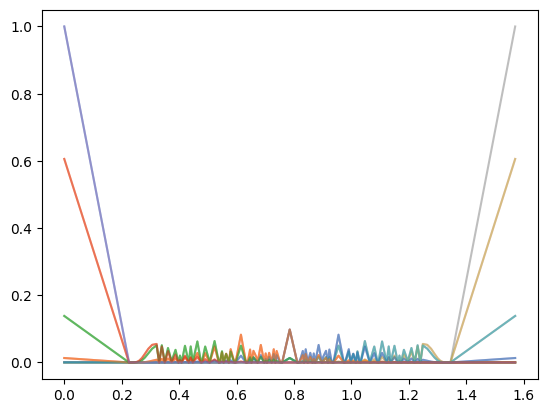

In [80]:
theta = 0.5 * np.pi

# show some of the pmfs for different deltas
delta_range = np.linspace(0, np.pi, 15)

# get the pmf for each theta
n=20
pmf_z = [get_multinom_arctan_pmf(n, theta, delta) for delta in delta_range]

# plot the pmfs
plt.figure()
for pmf in pmf_z:
    plt.plot(pmf["pmf_delta_tilde"], pmf["pmf"], alpha=0.5)

plt.show()

In [87]:
def calculate_multinom_delta_stats(theta, delta_samples, n):
    delta_range = np.linspace(0, np.pi / 2, delta_samples)
    pmf_z = [get_multinom_arctan_pmf(n, theta, delta) for delta in delta_range]
    
    variances = []
    means = []

    for pmf in pmf_z:
        delta_tilde = pmf["pmf_delta_tilde"]
        pmf = pmf["pmf"]

        mean = np.sum(delta_tilde * pmf)
        var = np.sum((delta_tilde) ** 2 * pmf) - mean ** 2

        means.append(mean)
        variances.append(var)

    return theta, delta_range, means, variances


In [88]:
delta_samples = 501
n_range = [40, 200]
theta = 0.5 * np.pi

delta_range = np.linspace(0, np.pi / 2, delta_samples)

In [91]:
# get the means and variances for each n
means = []
variances = []

for n in n_range:
    _, _, m, v = calculate_multinom_delta_stats(theta, delta_samples, n)
    means.append(m)
    variances.append(v)

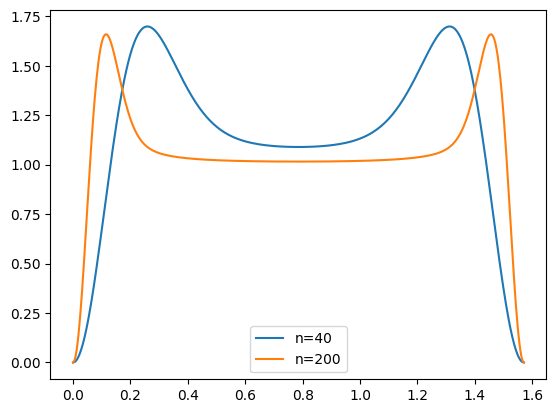

In [92]:
plt.figure()
for n in n_range:
    plt.plot(
        delta_range,
        np.multiply(2 * n * np.sin(theta) ** 2, variances[n_range.index(n)]),
        label=f"n={n}",
    )

plt.legend()
plt.show()

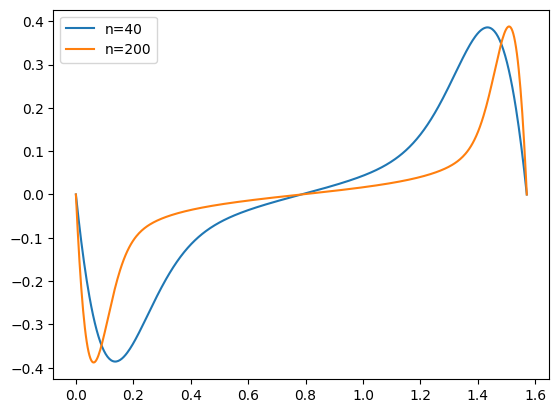

In [93]:
plt.figure()
for n in n_range:
    plt.plot(delta_range, np.multiply(np.sqrt(n), means[n_range.index(n)] - delta_range), label=f'n={n}')

plt.legend()
plt.show()